# Analyse ERA5 demand for NEM

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import pickle

import shap
# shap.initjs()

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [11]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [12]:
N_FEATURES = "parsimonious"

In [13]:
DETREND = False

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load model data

In [15]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [16]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    pred_ds[r] = ds

In [17]:
# Population density mask, remove weekends and Xmas
features = fn.read_results(
    "feature_selection", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [18]:
hyperparameters = fn.read_results(
    "hyperparameters", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

### SHAP analysis

How do the predictors contribute to the predictions for the new training period (2010-2019) and the new test period (1959-2022)?

In [19]:
write_SHAP = False

In [22]:
dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [23]:
trainX_dict = {}
testX_dict = {}

shap_train = {}
shap_test = {}

explainer_train = {}
explainer_test = {}

for r in regions:
    cal = fn.get_calendar(MARKET, r)
    dem = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).sel(region=r)
    train_pred = fn.remove_time(pred_ds[r], REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).drop(["demand", "is_workday"])
    test_pred = pred_ds[r].drop(["demand"])
        
    train_X = train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).to_dataframe().values
    test_X = test_pred.to_dataframe().values
    train_y = dem.loc[slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))].values
    
    trainX_dict[r] = train_X
    testX_dict[r] = test_X
    
    filename_train = fn.get_filename(
        "SHAP_train", MARKET, r, MASK_NAME,
        FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
        REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
    )
    if DETREND:
        filename_train = filename_train + "_detrended"
        
    filename_test = fn.get_filename(
        "SHAP_test", MARKET, r, MASK_NAME,
        FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
        REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
    )
    if DETREND:
        filename_test = filename_test + "_detrended"
    
    if write_SHAP:
        from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
        
        # Finalise model
        rf = ExtraTreesRegressor(
            n_estimators=int(hyperparameters[r].loc["n_estimators"].values),
            min_samples_leaf=int(hyperparameters[r].loc["min_samples_leaf"].values),
            max_depth=int(hyperparameters[r].loc["max_depth"].values),
            max_leaf_nodes=int(hyperparameters[r].loc["max_leaf_nodes"].values),
            random_state=0,
        )

        model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
        model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)

        explainer = shap.Explainer(rf)
        # explain_train = explainer.shap_values(train_X)
        # explain_test = explainer.shap_values(test_X)
        explain_train = explainer(train_X)
        explain_test = explainer(test_X)
        
        # Pickle entire explainer
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "wb") as f:
             pickle.dump(explain_train, f)

        # Write SHAP values separately to csv
        shap_train[r] = pd.DataFrame(
            explain_train.values,
            index=pd.to_datetime(train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR)))["time"].values),
            columns=list(train_pred.data_vars)
        )
        shap_train[r].to_csv(
            RESULTS_PATH + "/SHAP/random_forest/" + filename_train + ".csv",
        )

        # Now for test
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "wb") as f:
             pickle.dump(explain_test, f)

        shap_test[r] = pd.DataFrame(
            explain_test.values,
            index=pd.to_datetime(test_pred.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR)))["time"].values),
            columns=list(test_pred.data_vars)
        )

        shap_test[r].to_csv(
            RESULTS_PATH + "/SHAP/random_forest/" + filename_test + ".csv",
        )
        
    else:
        # shap_train[r] = pd.read_csv(
        #     RESULTS_PATH + "/SHAP/random_forest/" + filename_train + ".csv",
        #     index_col=0,
        #     parse_dates=True
        # )
        # shap_test[r] = pd.read_csv(
        #     RESULTS_PATH + "/SHAP/random_forest/" + filename_test + ".csv",
        #     index_col=0,
        #     parse_dates=True
        # )
        
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "rb") as f:
             explainer_train[r] = pickle.load(f)
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "rb") as f:
             explainer_test[r] = pickle.load(f)

In [24]:
def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
    """
    Custom shap summary plot
    """
    pl = shap.summary_plot(
        vals,
        features,
        feature_names=feature_names,
        plot_type="dot",
        cmap="viridis",
        color_bar=colorbar,
        show=False,
        plot_size=None
    )

    ax = plt.gca()
    for pos in ["top", "bottom", "left", "right"]:
        ax.spines[pos].set_visible(True)

    # xmin = roundup(np.min(vals), 1)
    # xmax = roundup(np.max(vals), 1)
    # if xmax - xmin > 800:
        # gap = 4000
    # elif xmax - xmin > 5000:
        # gap = 1000
    # else:
        # gap = 500
#     
    # ax.set_xticks(np.arange(xmin, xmax, gap))
    ax.axes.grid(visible=True)
    ax.axvline(0, c="k")
    ax.set_xlabel("SHAP value " + r"[GWh d$^{-1}$]", fontsize=fontsize)
    
    ax.yaxis.label.set_size(fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
    # ax.set_yticklabels(range(vals.shape[1]), labelpad=0)
    
    # fig.colorbar(pl, ax=ax)
    
    return ax

Text(0.5, 0, 'Feature value')

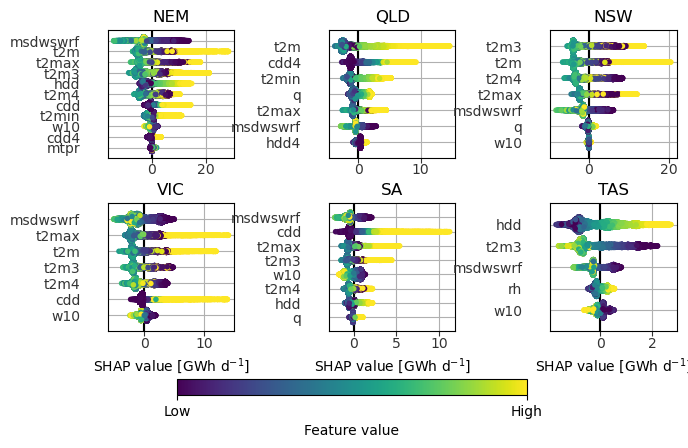

In [49]:
fig = plt.figure(figsize=(7,4))

for i, r in enumerate(regions):
    
    fig.add_subplot(2, 3, i+1)
    a = plot_shap(
        explainer_test[r].values / 1000,
        testX_dict[r],
        fn.parse_features(fn.sel_model(features[r])["feature_names"])[::-1],
        colorbar=False
    )
    a.set_title(r)
    # a.text(0.8, 0.05, r, transform=a.transAxes)
    
    if i in [0, 1, 2]:
        a.set_xlabel("")

plt.subplots_adjust(wspace=0.75, hspace=0.35)
    
# Figure legend
cmap = plt.get_cmap('viridis')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array([])

cax = fig.add_axes([0.26, 0.0, 0.5, 0.04])
cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
cbar.ax.set_xticklabels(["Low", "High"])
cbar.ax.set_xlabel("Feature value")

### Compare statistics of train (2010-2019) vs test (1959-2022)

In [25]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [26]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel(xlabel)

In [27]:
first_vars = [predictions[r].columns[0] for r in regions]

In [28]:
first_vars

['t2max', 't2max', 't2max', 't2max', 't2max', 'msdwswrf']

In [29]:
first_vars_units = ["[deg C]", "[deg C]", "[deg C]", "[deg C]", "[deg C]", r"[W m$^{-2}$]"]

In [30]:
second_vars = [predictions[r].columns[1] for r in regions]
second_vars

['msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'hdd']

In [31]:
second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", "[deg C]"]

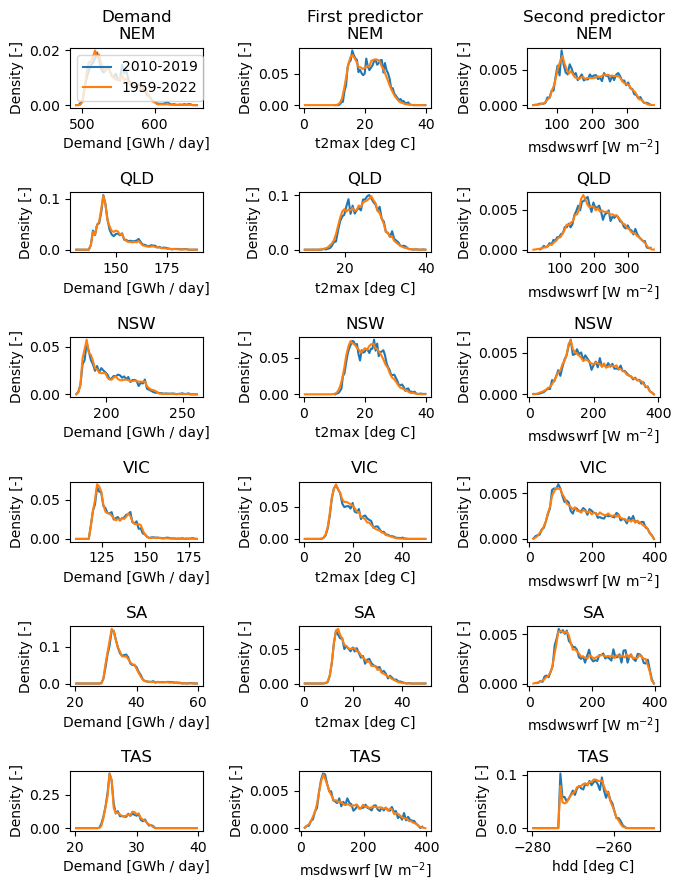

In [134]:
fig, ax = plt.subplots(6, 3, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     

    # ax[i,0].text(0.02, 0.8, r, transform=ax[i,0].transAxes)
    if i == 0:
        ax[i,0].legend()

    # Most important variable histograms
    if first_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2022")) + offset)
    ]
    plot_hist(ax[i,1], hists, ["2010-2019", "1959-2022"], first_vars[i] + " " + first_vars_units[i]) 
    
    # Second most important variable histograms
    if second_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("1959", "2022")) + offset)
    ]
    plot_hist(ax[i,2], hists, ["2010-2019", "1959-2022"], second_vars[i] + " " + second_vars_units[i]) 
    
    if i == 0:
        ax[i,0].set_title("Demand\n" + r)
        ax[i,1].set_title("First predictor\n" + r)
        ax[i,2].set_title("Second predictor\n" + r)
    else:
        ax[i,0].set_title(r)
        ax[i,1].set_title(r)
        ax[i,2].set_title(r)

plt.tight_layout()

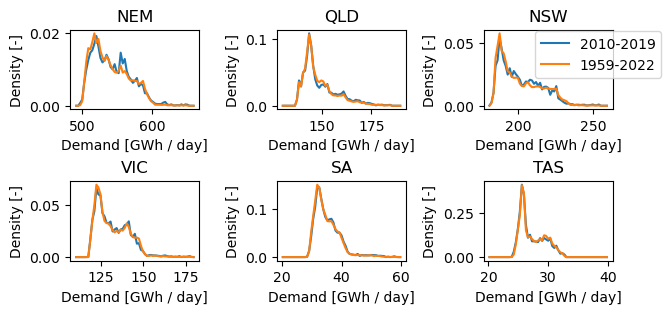

In [135]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000)
    ]
    plot_hist(ax.flatten()[i], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     
    
    ax.flatten()[i].set_title(r)
    
ax[0,2].legend(loc=(0.4, 0.4))
plt.subplots_adjust(wspace=0.6, hspace=0.9)

### Time series of extreme demand days

In [32]:
def normalise(da, period=slice(None, None), dim="time"):
    """
    Normalise by removing mean and dividing by standard deviation
    """
    return (da - da.sel({dim: period}).mean(dim)) / da.sel({dim: period}).std(dim)

In [33]:
def extreme_days(da, q, period=slice(None, None), dim="time"):
    """
    Days above q, where q is computed over period
    """
    thresh = da.sel({dim: period}).quantile(q, dim)
    return da.where(da > thresh)

In [34]:
def plot_2d_series(ax, da, title):
    """
    Plot 2d time series
    """
    da.assign_coords({"region": range(6)}).plot(ax=ax)
    ax.set_yticks(range(6))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.set_title(title)

In [35]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [36]:
baseline = slice("1990", "2019")

In [37]:
q = 1 - 1 / (365 * 1)
print(q)

0.9972602739726028


In [38]:
ext_dpy = extreme_days(demand, q, baseline).resample(time="1YS").count()

In [39]:
ext_dpy.sum("time")

<xarray.DataArray 'demand' (region: 6)>
array([48, 47, 54, 47, 49, 75])
Coordinates:
  * region    (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'
    quantile  float64 0.9973

In [40]:
# Normalised annual mean demand
norm_mean = normalise(demand, baseline).resample(time="1YS").mean()

In [41]:
# Normalised annual maximum demand
norm_max = normalise(demand, baseline).resample(time="1YS").max()

In [42]:
# Monthly occurrences of extreme days
monthly_ext = extreme_days(demand, q, baseline).sel(time=baseline).groupby("time.month").count()

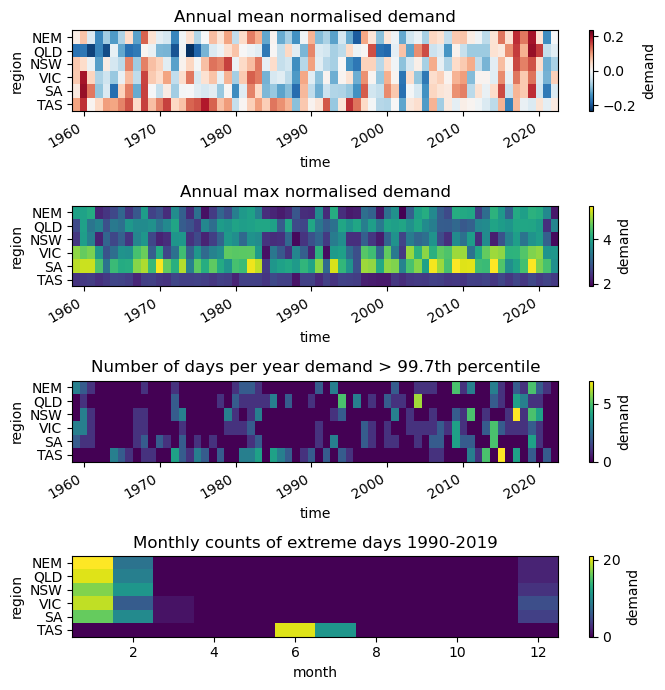

In [68]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7.))

plot_2d_series(ax[0], norm_mean, "Annual mean normalised demand")
plot_2d_series(ax[1], norm_max, "Annual max normalised demand")
plot_2d_series(ax[2], ext_dpy,
               "Number of days per year demand > " + str(np.round(q*100, 1)) + "th percentile"
              )
plot_2d_series(ax[3], monthly_ext, "Monthly counts of extreme days 1990-2019")
plt.tight_layout()

### Max demand on record

In [43]:
def get_days_around(date, n_before, n_after):
    """
    Return dates around a given date
    """
    return pd.date_range(date + pd.DateOffset(days=-n_before), date + pd.DateOffset(days=n_after), freq="D")

In [44]:
def normalise_monthly(da, dims=["time"], period=None):
    """
    Normalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))

In [45]:
def anomalise_monthly(da, dims=["time"], period=None):
    """
    Anomalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: x - x.mean(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: x - x.mean(dims))

In [46]:
def plot_max(demand_da, roll, predictors_ds, normalise, days_before, days_after, var_axis_offset, ylabels, suptitle):
    """
    Plot maximum demand for a given averaging period.
    
    demand_da: array of demand
    roll: int, average to take mean over
    predictors_ds: dataset of predictors
    normalise: bool, whether to normalise demand and predictors
    days_before, days_after: int, days around maximum to plot
    var_axis_offset: dict in format k: [ax, offset], where k is the index of the variable,
        ax is the axis index on which to plot this variable, and offset is the value to add.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    """
    demand_da = demand_da / 1000
    dem_roll = demand_da.rolling(time=roll).mean()
    
    if normalise:
        demand_da = normalise_monthly(demand_da)
        dem_roll = normalise_monthly(dem_roll)
    
    dem_max = dem_roll.idxmax("time")
    days_around = get_days_around(dem_max.values, days_before, days_after)
    
    dem_roll_sel = dem_roll.sel(time=days_around)
    dem_sel = demand_da.sel(time=days_around)
    
    preds = list(predictors_ds.data_vars)[:-1]
    print(preds)
    preds_data = [predictors_ds[preds[i]].sel(time=days_around) for i in range(len(preds))]
    
    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    dem_sel.plot(ax=ax[0,0], label="Daily")
    dem_roll_sel.plot(ax=ax[0,0], label=str(roll) + "-day")
    ax[0,0].set_title("")
    
    for i, var in enumerate(preds):
        if var_axis_offset[i] is not None:
            (preds_data[i] + var_axis_offset[i][0]).plot(ax=ax.flatten()[var_axis_offset[i][1]], label=preds[i])
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(dem_max.values, c="k")
        a.legend(loc=[0,1], ncols=2, frameon=False)
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))
        
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


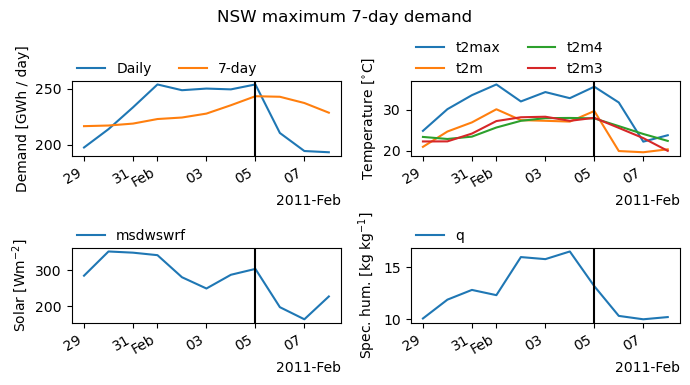

In [47]:
plot_max(
    demand.sel(region="NSW"),
    7,
    pred_ds["NSW"],
    False,
    7,
    3,
    {
        0: [-273.15, 1],
        2: [-273.15, 1],
        5: [-273.15, 1],
        6: [-273.15, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
    "NSW maximum 7-day demand"
)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


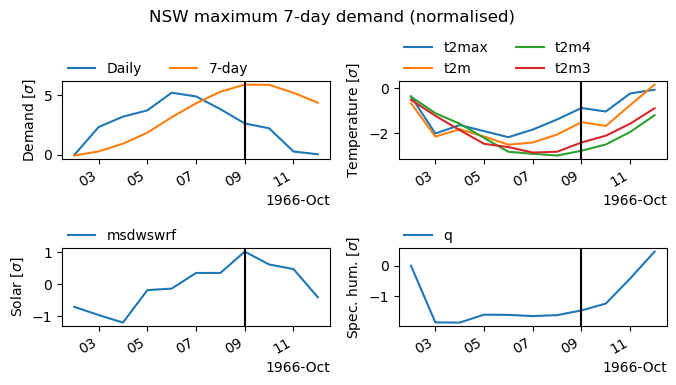

In [48]:
plot_max(
    normalise_monthly(demand.sel(region="NSW")),
    7,
    normalise_monthly(pred_ds["NSW"]),
    True,
    7,
    3,
    {
        0: [0, 1],
        2: [0, 1],
        5: [0, 1],
        6: [0, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
    "NSW maximum 7-day demand (normalised)"
)

### Composite evolution on extreme days

In [50]:
def get_cases(da, times, days_before, days_after):
    """
    Return an array that selects and reshapes da according to times provided, 
    with some days prior and after each time.
    """
    da_list = []
    for time in times:
        days_around = get_days_around(time, days_before, days_after)
        idx_days_around = range(-days_before, days_after+1)
        
        _da = da.sel(time=days_around)
        _da = _da.rename({"time": "days_around"})
        _da = _da.assign_coords({"days_around": idx_days_around})
        _da = _da.expand_dims({"time": [time]})
        da_list.append(_da)
    return xr.concat(da_list, "time")

In [126]:
def subset_events(da, window):
    """
    Returns last times from da that fall within a window.
    E.g. if you want events that occur within a week to be a single event,
    set window=7.
    """
    days_diff = da["time"].to_series().diff().dt.days # difference between days
    mask = days_diff < window # where dys fall within the window
    group = (~mask).cumsum() # Assign groups to events
    events = days_diff.groupby(group).tail(1) # final day of event    
    return da.sel(time=events.index) # Select events of da

In [108]:
roll = 7
days_before = 12
days_after = 5
event_window = 7

In [52]:
dem_roll = (demand / 1000).rolling(time=roll).mean()

In [53]:
q = 1 - 1 / (365 * 3)
print(q)

0.9990867579908675


In [128]:
ext_dict = {}

for r in regions:
    dem_ext = extreme_days(dem_roll.sel(region=r), q=q)
    dem_ext = dem_ext.dropna("time")
    dem_events = subset_events(dem_ext, event_window)
    
    ext_dict[r] = get_cases(dem_roll.sel(region=r), dem_events["time"].values, days_before, days_after)

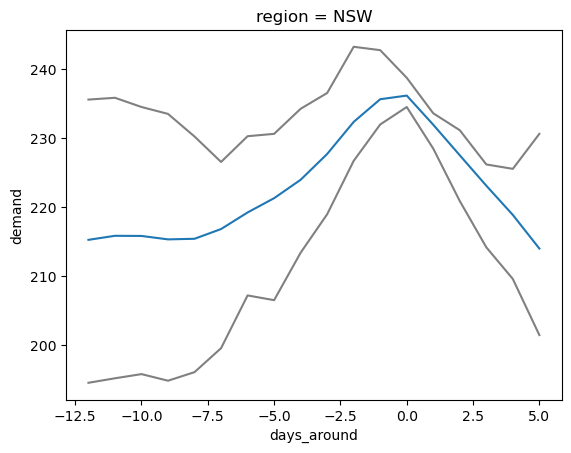

In [130]:
ext_dict["NSW"].mean("time").plot()
ext_dict["NSW"].min("time").plot(c="gray")
ext_dict["NSW"].max("time").plot(c="gray")

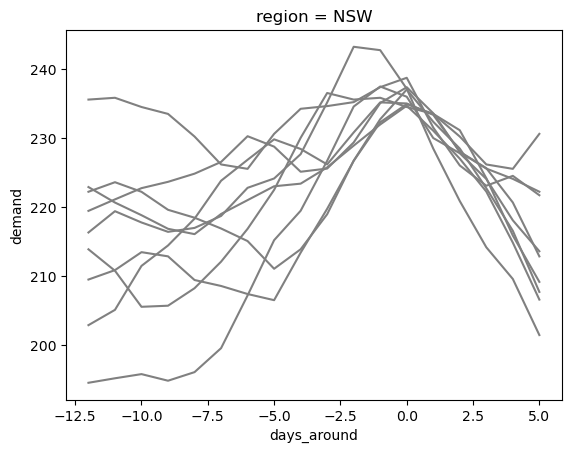

In [131]:
_ = ext_dict["NSW"].plot.line(x="days_around", c="gray", add_legend=False)